In [1]:
import pandas as pd
import numpy as np

In [2]:
def get_conf_scores_df(ct_file_path,dp_file_path):
    ct_file = pd.read_csv(ct_file_path,skiprows=1,sep=r'\s+',header=None)
    ct_file.columns = ['index','nucleotide','prev','next','binding','index_2']

    dp_file =pd.read_csv(dp_file_path,skiprows=1,sep='\t')
    dp_file.columns = ['index','binding','probability']

    merged = pd.merge(ct_file,dp_file,on=['index','binding'],how='left')
    merged = merged[['index','binding','probability']]

    column_name = 'probability'

# Convert -log10 probabilities to regular probabilities, ignoring NaN values
    merged[column_name] = np.where(merged[column_name].notna(),
                                    10 ** (-merged[column_name]),
                                    merged[column_name])
    
    return merged


In [3]:
Vehicle = get_conf_scores_df("bams/DMS_Vehicle_output/DMS_Vehicle_fold/structures/AR_5UTR.ct","bams/DMS_Vehicle_output/DMS_Vehicle_fold/dotplot/AR_5UTR.dp")

In [6]:
Vehicle.head()

,index,binding,probability
0,1,0,NaN
1,2,0,NaN
2,3,0,NaN
3,4,0,NaN
4,5,0,NaN


In [7]:
Vehicle = get_conf_scores_df("bams/DMS_Vehicle_output/DMS_Vehicle_fold/structures/AR_5UTR.ct","bams/DMS_Vehicle_output/DMS_Vehicle_fold/dotplot/AR_5UTR.dp")
ctrl_probs = Vehicle[["index","binding","probability"]]
ctrl_probs.fillna(0, inplace=True)
ctrl_probs.to_csv("Vehicle_basepair_probabilities.tsv",index=False,sep='\t')

In [8]:
Zota = get_conf_scores_df("bams/DMS_Zota_output/DMS_Zota_fold/structures/AR_5UTR.ct","bams/DMS_Zota_output/DMS_Zota_fold/dotplot/AR_5UTR.dp")
ctrl_probs = Zota[["index","binding","probability"]]
ctrl_probs.fillna(0, inplace=True)
ctrl_probs.to_csv("Zota_basepair_probabilities.tsv",index=False,sep='\t')

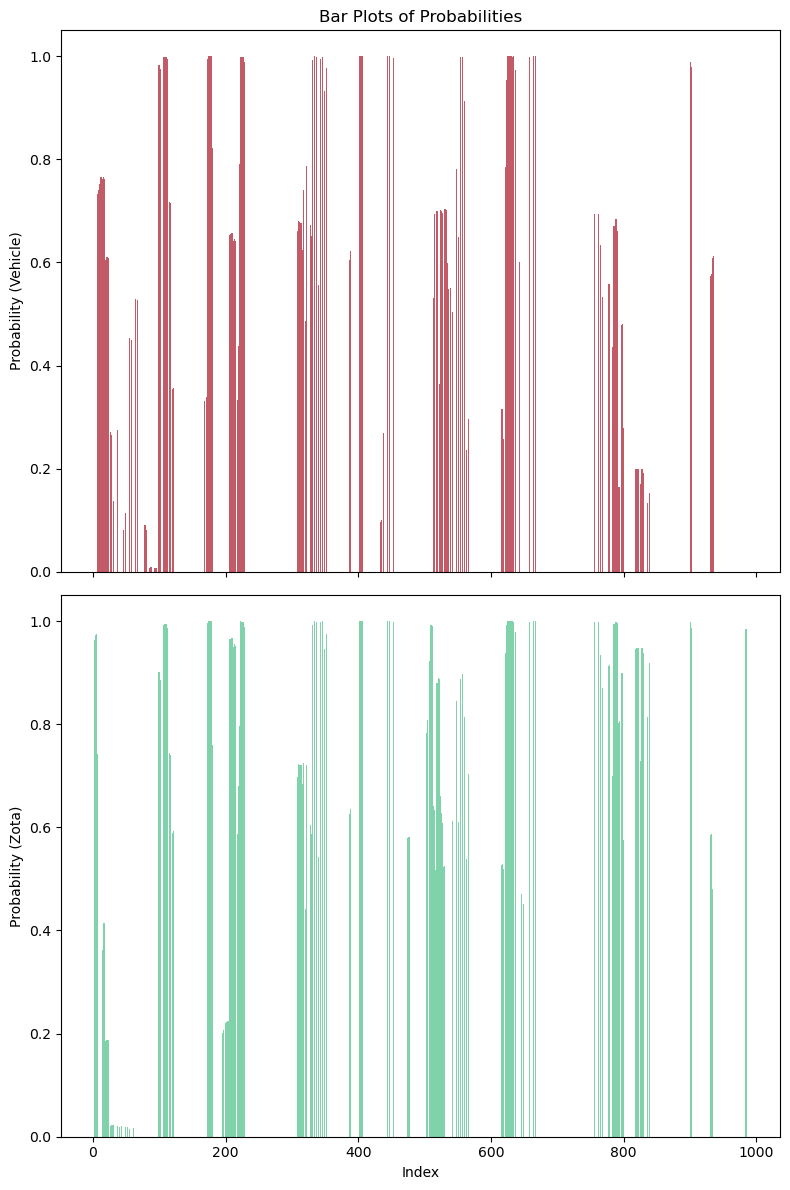

In [14]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(8, 12), sharex=True)

# Plot DataFrame 1
axs[0].bar(Vehicle['index'], Vehicle['probability'], color='#a81627', alpha=0.7)
axs[0].set_ylabel('Probability (Vehicle)')
axs[0].set_title('Bar Plots of Probabilities')

# Plot DataFrame 2
axs[1].bar(Zota['index'], Zota['probability'], color='#49bf86', alpha=0.7)
axs[1].set_ylabel('Probability (Zota)')

axs[1].set_xlabel('Index')

plt.tight_layout()
plt.show()

In [15]:
%load_ext rpy2.ipython

In [16]:
%%R -i Vehicle -i Zota
head(Vehicle)

  index binding probability
0     1       0         NaN
1     2       0         NaN
2     3       0         NaN
3     4       0         NaN
4     5       0         NaN
5     6       0         NaN


In [21]:
%%R
library(dplyr)
probabilities <- cbind(Vehicle$probability,Zota$probability) %>% as.data.frame()
head(probabilities)
colnames(probabilities) <- c("Vehicle","Zota")

In [22]:
%%R
probabilities <- replace(probabilities,is.na(probabilities),0)

In [24]:
%%R
probabilities <- probabilities %>% mutate(Zota_vs_Veh=Zota-Vehicle)

In [29]:
%%R
probabilities$nt <- 1:nrow(probabilities)

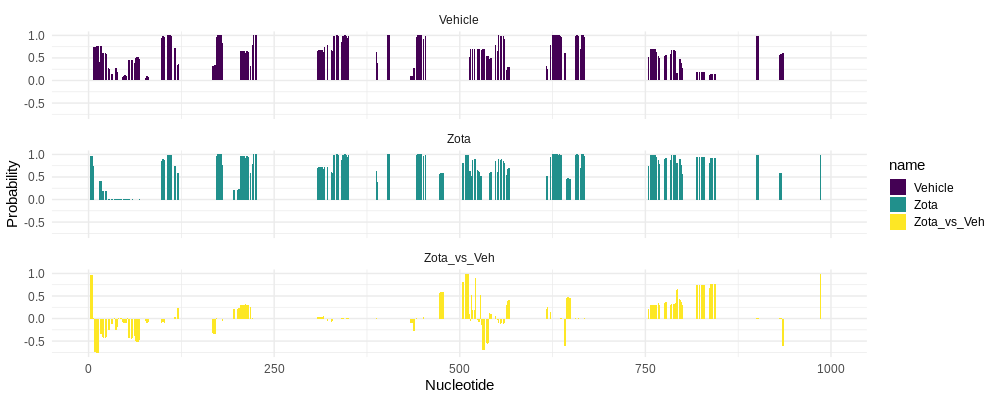

In [34]:
%%R -w 1000 -h 400
probabilities_long <- tidyr::pivot_longer(probabilities, cols = c("Vehicle","Zota","Zota_vs_Veh"), values_to = "Probability")
library(viridis)
library(ggplot2)

# Set the Simpson-themed color palette
simpsons_palette <- viridis(3, option = "I")

# Update the ggplot code
options(repr.plot.width=20)
ggplot(probabilities_long, aes(x = nt, y = Probability, fill = name)) +
  geom_bar(stat = "identity") +  # Add black outlines
  facet_wrap(~ name, ncol = 1) +
  labs(x = "Nucleotide", y = "Probability") +
  theme_minimal(base_size = 15) +
  scale_fill_manual(values = simpsons_palette) 